# Monet Painting Generation with GAN
### Mini Project for DTSA 5511: Introduction to Deep Learning
#### University of Colorado, Boulder - Master of Science in Data Science

**By:** Andrea Francu  
**Version:** 1.0  
**Date:** Februay 16, 2025

The aim of this project is to build a Generative Adversarial Network by creating and training a generator and a discriminator to generate 7,000 to 10,000 Monet-style images. This project is part of Kaggle's "Getting Started" competition (https://www.kaggle.com/competitions/gan-getting-started) and serves as a mini project for CU Boulder’s DTSA 5511 course. The primary objective with regards to the course is to get a hands on introduction to GAN's rather than optimizing for the highest-performing model through multiple iterations.

---

In [21]:
# import necessary libraries
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
import zipfile
import shutil

## Data Overview
The dataset provided for this challenge includes directories of Monet paintings, which will be used to train the model, and photos that will be transformed by the model with a Monet-style. Both sets of images come in two forms, either JPEG or TFRecords. The Kaggle page recommends using TFRecords to become more familiar with a new data format, so that's the set I will be using.

TFRecords are a TensorFlow-specific format for storing large datasets with sequences of binary records.

- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [22]:
# gather paths of each dataset
monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_tfrec_path = '/kaggle/input/gan-getting-started/photo_tfrec'
monet_jpg_path = '/kaggle/input/gan-getting-started/monet_jpg'
photo_jpg_path = '/kaggle/input/gan-getting-started/photo_jpg'

# number of photos in all given folders
print(f"Number of Monet TFRecords: {len(os.listdir(monet_tfrec_path))}")
print(f"Number of photo TFRecords: {len(os.listdir(photo_tfrec_path))}")

print(f"Number of Monet jpg: {len(os.listdir(monet_jpg_path))}")
print(f"Number of photo jpg: {len(os.listdir(photo_jpg_path))}")

Number of Monet TFRecords: 5
Number of photo TFRecords: 20
Number of Monet jpg: 300
Number of photo jpg: 7038


---
## Exploratory Data Analysis (EDA)

### Data Cleaning and Preparation
Was initially resizing to 256x256 but this resulted in memory issues, same with 128x128

In [23]:
# decode JPEGs from TFRecord
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) # decode into 3 channel (RGB) image
    image = tf.image.resize(image, [128, 128]) # resize to 128x128
    image = tf.cast(image, tf.float32) # ensure float32 type
    image = (image / 127.5) - 1 #/= 255.0  # normalize to [-1,1]
    return image

# parse each example
def parse_tfrec(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # store image 
        "image_name": tf.io.FixedLenFeature([], tf.string) # and image name
    }
    example_msg = tf.io.parse_single_example(example, features) # convert raw data to structured format
    image = decode_image(example_msg['image']) # image then decoded using previous function
    return image

# load in datasets for visualization purposes (individually)
def load_dataset_viz(tfrecord_path):
    dataset = tf.data.TFRecordDataset(filenames = [tfrecord_path]) # create TF dataset
    dataset = dataset.map(parse_tfrec) # put each image through previous function
    return dataset
    
# load in datasets for training purposes (in batches)
def load_dataset_training(tfrecord_path, batch_size = 1):
    dataset = tf.data.TFRecordDataset(filenames = [tfrecord_path]) # create TF dataset
    dataset = dataset.map(parse_tfrec) # put each image through previous function
    dataset = dataset.batch(batch_size) # batch data for efficiency
    dataset = dataset.prefetch(tf.data.AUTOTUNE) # prefetch images for better performance
    return dataset


# go through each tfrec and add to files
monet_tfrec_files = [os.path.join(monet_tfrec_path, f) for f in os.listdir(monet_tfrec_path) if f.endswith('.tfrec')]
photo_tfrec_files = [os.path.join(photo_tfrec_path, f) for f in os.listdir(photo_tfrec_path) if f.endswith('.tfrec')]

# load in each dataset for visualization
monet_imgs = load_dataset_viz(monet_tfrec_files)
photo_imgs = load_dataset_viz(photo_tfrec_files)

# load in each dataset for training
BATCH_SIZE = 32
monet_data = load_dataset_training(monet_tfrec_files, BATCH_SIZE)
photo_data = load_dataset_training(photo_tfrec_files, BATCH_SIZE)

### Data Visualization
Once the files are loaded in to a structure we can use, we can take a look at some visuals. A simple first look at the data is just looking at the images themselves, from both Monet and photo datasets.

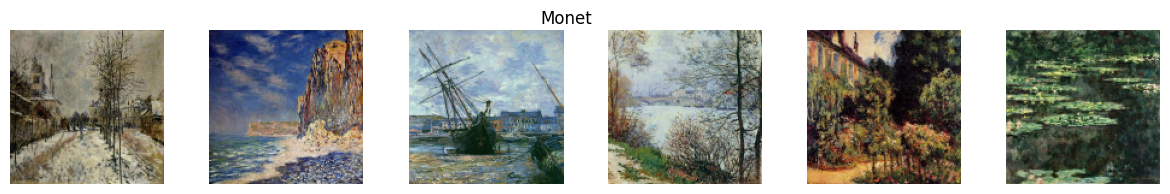

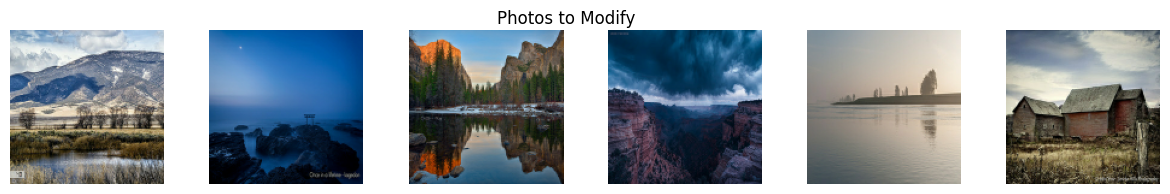

In [24]:
def visualize(dataset, title):
    plt.figure(figsize = (15, 2)) # create figure
    if isinstance(dataset, list): # check if dataset is a list
        for i, image in enumerate(dataset[:6]): # go through 6 images from dataset
            plt.subplot(1, 6, i+1) # loop through subplots
            if image.shape[0] > 1: # check if its a batch of images
                image = image[0]
            image = ((image.numpy() + 1) * 127.5).astype(np.uint8)
            plt.imshow(image) 
            plt.axis('off') 
    else: # assume dataset is a TensorFlow dataset
        for i, image in enumerate(dataset.take(6)): # go through 6 images from dataset
            plt.subplot(1, 6, i+1) # loop through subplots
            image = ((image.numpy() + 1) * 127.5).astype(np.uint8)
            plt.imshow(image) 
            plt.axis('off') 
    plt.suptitle(title) 
    plt.show()

visualize(monet_imgs, "Monet")
visualize(photo_imgs, "Photos to Modify")

Some other visualizations to give us an idea of the spread of data include histograms of image pixel values, as well as some basic statistical metrics related to those values, like mean and standard deviation.

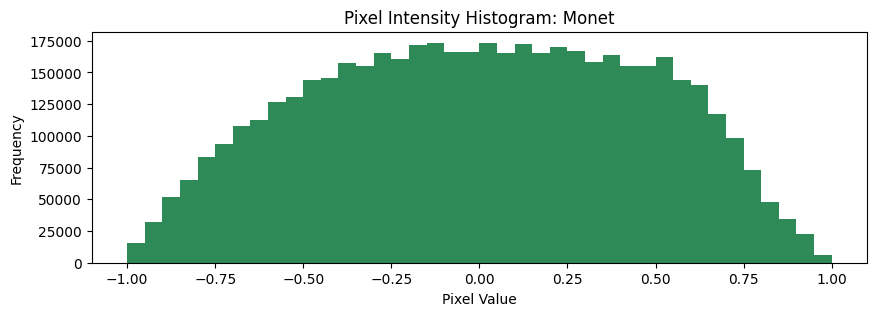

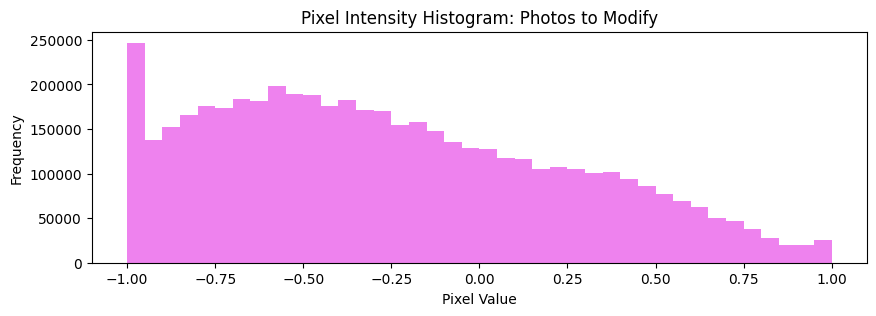

In [25]:
# plot a histogram of the pixels 
def plot_pixel_histogram(dataset, title, color):
    pixel_values = []
    for image in dataset.take(100):  # sample 100 images for efficiency
        pixel_values.extend(image.numpy().flatten())  # flatten image and collect pixel values
    
    plt.figure(figsize = (10, 3)) # create figure
    plt.hist(pixel_values, bins = 40, color = color) # plot histogram of pixel values
    plt.title(f"Pixel Intensity Histogram: {title}") # title
    plt.xlabel("Pixel Value") 
    plt.ylabel("Frequency")
    plt.show()

# plot histograms for both datasets
plot_pixel_histogram(monet_imgs, "Monet", "seagreen")
plot_pixel_histogram(photo_imgs, "Photos to Modify", "violet")

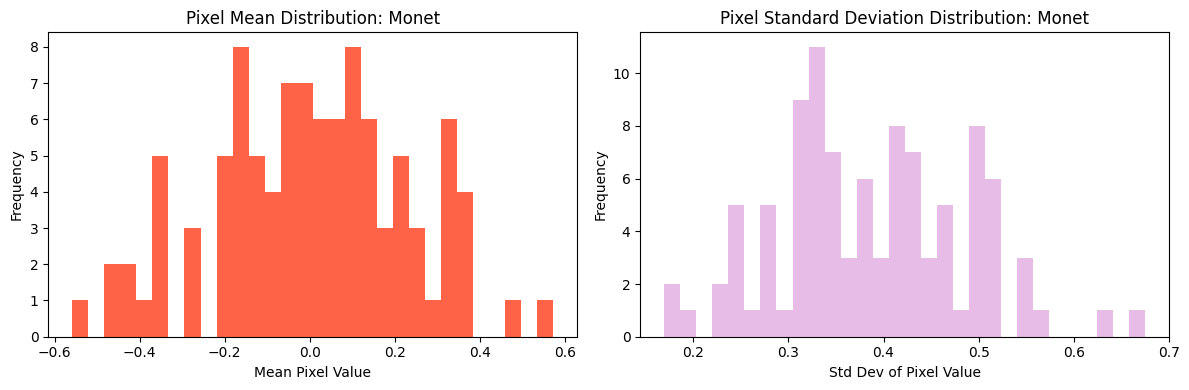

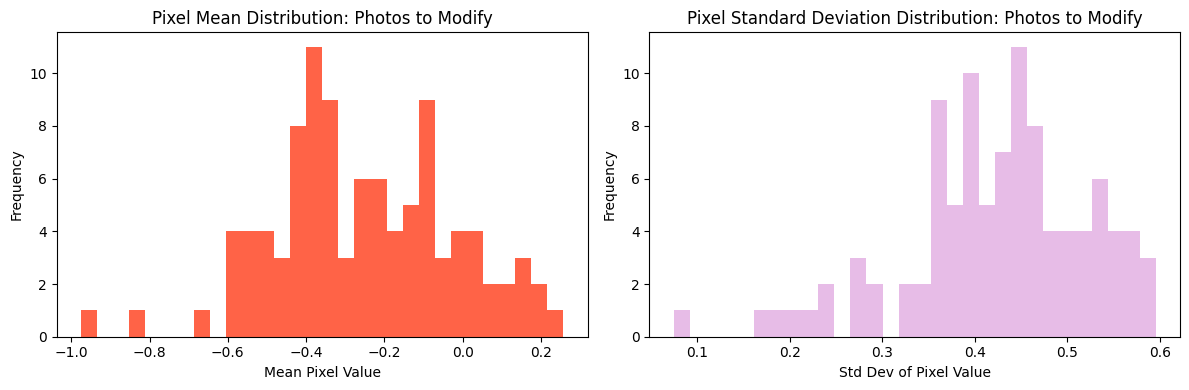

In [26]:
# plot statistics about the pixels
def plot_image_stats(dataset, title):
    means = []
    stds = []
    for image in dataset.take(100):  # sample 100 images for efficiency
        means.append(image.numpy().mean()) # add mean of each image pixels
        stds.append(image.numpy().std()) # add std of each image pixels

    # plot the mean
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(means, bins = 30, color = "tomato")
    plt.title(f"Pixel Mean Distribution: {title}")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Frequency")

    # plot the standard deviation
    plt.subplot(1, 2, 2)
    plt.hist(stds, bins=30, color = 'plum', alpha=0.7)
    plt.title(f"Pixel Standard Deviation Distribution: {title}")
    plt.xlabel("Std Dev of Pixel Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# plot stats for both datasets
plot_image_stats(monet_imgs, "Monet")
plot_image_stats(photo_imgs, "Photos to Modify")

---
## Model Architecture
To build a GAN, we need two components: a generator and a discriminator. The generator's task is to create images in the style of Monet by learning from Monet paintings and transforming regular images to mimic his artistic style. The discriminator tries to distinguish between actual Monet paintings and the images generated by the generator. Both models are trained simultaneously, with the generator learning to improve its creations and the discriminator becoming better at detecting the generated images. The process becomes stable once the discriminator can no longer tell real images, in this case the Monet paintings, apart from generated ones. 

### Hyperparameter Tuning
Building the GAN required extensive experimentation with model architecture and hyperparameters to balance performance and computational resources. While the original competition used 256x256 images, resource constraints necessitated scaling down to 128x128. Key parameters tuned included:

- Batch sizes
- Learning rates for both networks
- Network depth and layer configurations
- Learning rate schedulers

A major challenge was balancing the training of both networks - if one network improved too quickly, the other would fail to learn effectively. This required careful tuning of learning rates and optimization parameters. Another big challenge is the limited GPU resources. Many of the initial network configurations may have resulted in better performance, but ran into OOM issues. One architecture I tried using started with a latent vector input to the generator, random noise, rather than the input image, but this proved to be even more difficult to improve.

### Generator Structure
The generator uses a U-Net style architecture with skip connections. It downsamples the input through convolutional layers, then upsamples back to the original size. Group normalization and activation functions help stabilize training and introduce non-linearity.

In [27]:
generator = keras.Sequential([
    keras.Input(shape=(128, 128, 3)),  # input layer accepts 128x128 RGB images
    
    # downsampling path
    layers.Conv2D(32, kernel_size=7, padding="same"),  # initial feature extraction
    layers.GroupNormalization(groups=1),  # normalize features for training stability
    layers.LeakyReLU(0.2),  # activation allowing small negative values
    
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),  # reduce spatial dimensions, double features
    layers.GroupNormalization(groups=1),
    layers.LeakyReLU(0.2),
    
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),  # further reduction and feature extraction
    layers.GroupNormalization(groups=1),
    layers.LeakyReLU(0.2),
    
    # upsampling path
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),  # start reconstructing image
    layers.GroupNormalization(groups=1),
    layers.ReLU(),  # standard activation for upsampling
    
    layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),  # continue upsampling
    layers.GroupNormalization(groups=1),
    layers.ReLU(),
    
    layers.Conv2D(3, kernel_size=7, padding="same", activation="tanh")  # output layer for RGB image
])

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization                  │ (None, 128, 128, 32)        │              64 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_1                │ (None, 64, 64, 64)          │             128 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_2                │ (None, 32, 32, 128)         │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_3                │ (None, 64, 64, 64)          │             128 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 32)        │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_4                │ (None, 128, 128, 32)        │              64 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 3)         │           4,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,051 (1.29 MB)

 Trainable params: 338,051 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

### Discriminator Structure
The discriminator uses a series of convolutional layers to compress the image into a single binary output. Dropout layers prevent overfitting, while LeakyReLU activations allow for better gradient flow.

In [28]:
discriminator = keras.Sequential([
    keras.Input(shape=(128, 128, 3)),  # input layer for RGB images
    
    layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),  # initial feature detection
    layers.LeakyReLU(0.2),  # prevent dying ReLU problem
    layers.Dropout(0.3),  # reduce overfitting
    
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),  # increase feature complexity
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),  # final feature extraction
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
    
    layers.Flatten(),  # prepare for classification
    layers.Dense(1, activation="sigmoid")  # binary output: real or fake
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,369 (774.88 KB)

 Trainable params: 198,369 (774.88 KB)

 Non-trainable params: 0 (0.00 B)

### Loss Function, Optimizer, and Training Loop
The GAN training process involves two networks with opposing objectives: the generator tries to create convincing fake images while the discriminator learns to spot them. The networks use separate loss functions and optimizers, with careful tuning required to maintain training stability.

In [29]:
# loss function for comparing generated images to their labels
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(gen_imgs):
    # use label smoothing (0.9) for more stable training
    loss = cross_entropy(tf.ones_like(gen_imgs) * 0.9, gen_imgs)
    return loss

def add_label_noise(labels, noise_rate=0.05):
    # randomly flip some labels to prevent overconfidence
    random_values = tf.random.uniform(labels.shape)
    noisy_labels = tf.where(random_values < noise_rate, 1 - labels, labels)
    return noisy_labels

def discriminator_loss(real_imgs, gen_imgs):
    # add noise to labels for training stability
    real_labels = add_label_noise(tf.ones_like(real_imgs) * 0.9)
    fake_labels = add_label_noise(tf.zeros_like(gen_imgs))
    
    # calculate loss for real and fake images
    real_loss = cross_entropy(tf.ones_like(real_imgs), real_imgs)
    gen_loss = cross_entropy(tf.zeros_like(gen_imgs), gen_imgs)
    return (real_loss + gen_loss)

def cycle_loss(real_image, cycled_image, lambda_cycle=3.0):
    # ensure translated images can be converted back to original
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real, same, lambda_identity=0.5):
    # preserve input when translating images of correct domain
    return lambda_identity * tf.reduce_mean(tf.abs(real - same))

# define generators and discriminators for both domains
gen_G = generator  # photo to Monet
gen_F = generator  # Monet to photo
disc_X = discriminator  # for photos
disc_Y = discriminator  # for Monet paintings

# create optimizers with gradient clipping
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, clipnorm=1.0)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, clipnorm=1.0)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # generate fake images in both directions
        fake_y = gen_G(real_x)
        fake_x = gen_F(real_y)
        
        # identity mappings
        same_x = gen_F(real_x)
        same_y = gen_G(real_y)
        
        # cycle consistency
        cycled_x = gen_F(fake_y)
        cycled_y = gen_G(fake_x)
        
        # discriminator predictions
        disc_real_x = disc_X(real_x)
        disc_fake_x = disc_X(fake_x)
        disc_real_y = disc_Y(real_y)
        disc_fake_y = disc_Y(fake_y)
        
        # calculate all losses
        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)
        cycle_x_loss = cycle_loss(real_x, cycled_x)
        cycle_y_loss = cycle_loss(real_y, cycled_y)
        identity_x_loss = identity_loss(real_x, same_x)
        identity_y_loss = identity_loss(real_y, same_y)
        
        # combine losses
        total_gen_loss = gen_G_loss + gen_F_loss + cycle_x_loss + cycle_y_loss + identity_x_loss + identity_y_loss
        total_disc_loss = (
            discriminator_loss(disc_real_x, disc_fake_x) +
            discriminator_loss(disc_real_y, disc_fake_y)
        )

    # calculate and apply gradients
    gen_gradients = tape.gradient(total_gen_loss, gen_G.trainable_variables + gen_F.trainable_variables)
    disc_gradients = tape.gradient(total_disc_loss, disc_X.trainable_variables + disc_Y.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradients, gen_G.trainable_variables + gen_F.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, disc_X.trainable_variables + disc_Y.trainable_variables))

    return total_gen_loss, total_disc_loss

def training_loop(epochs):
    # track losses for monitoring training progress
    gen_losses = []
    disc_losses = []
    
    for epoch in range(epochs):
        start_time = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        batch_count = 0
        
        # train on each batch
        for photos, monets in zip(photo_data, monet_data):
            gen_loss, disc_loss = train_step(photos, monets)
            total_gen_loss += gen_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            batch_count += 1

        # calculate average losses
        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        clear_session()  # free GPU memory
        
    print(f"Done training!")
    return gen_losses, disc_losses

# start training process
gen_losses, disc_losses = training_loop(25)

Done training!


### Visualizing Model Performance
Let's take a look at the losses over each epoch for both the generator and discriminator. These won't necessarily be dropping each epoch, since each network's "adversary" is also improving simultaneously.

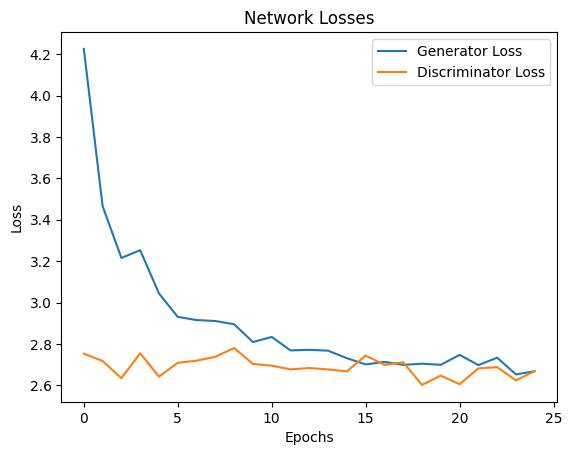

In [30]:
def plot_losses(gen_losses, disc_losses):
    plt.figure()
    plt.plot(gen_losses, label = "Generator Loss")
    plt.plot(disc_losses, label = "Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Network Losses")
    plt.legend()
    plt.show()

plot_losses(gen_losses, disc_losses)

### Generate Monet-like Images
After finalizing the model architecture, we can now generate the competition's required images and evaluate sample outputs to assess the quality of our Monet-style transformations. For this, I've used the 7028 images provided as inputs.

In [31]:
# function to apply the generator on the input images - no training because thats completed
def make_monet(num_images = 7038):
    generated_monets = []

    for i, photo in enumerate(photo_data.take(num_images)):
        gen_monet = generator(photo, training = False) # generate Monet-style image
        generated_monets.append(gen_monet) # append generated Monet 
    
    return generated_monets

generated_monets = make_monet()

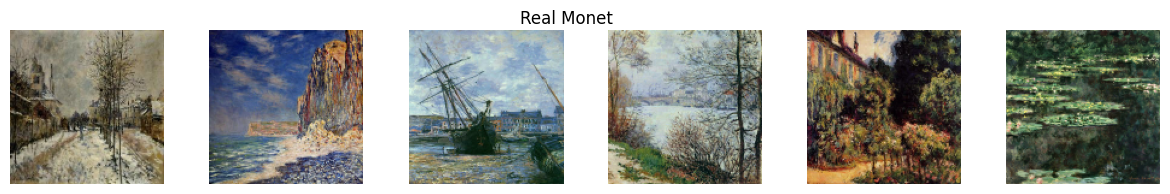

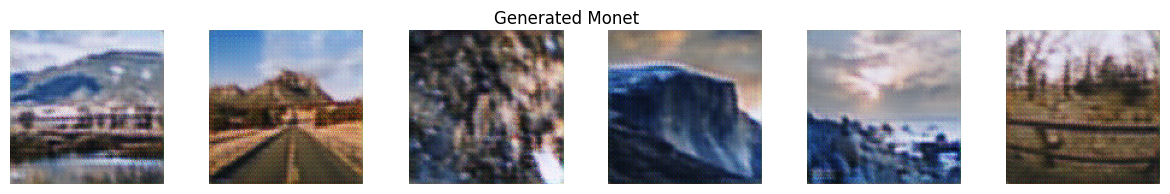

In [32]:
# can use visualization function from earlier to see the results
visualize(monet_imgs, "Real Monet")
visualize(generated_monets, "Generated Monet")

### Making Submission
Finally, we can create our submission for the Kaggle competition using the best

In [33]:
def save_images(generated_monets, output_path='images.zip'):
   # create temporary directory
   temp_dir = 'temp_images'
   os.makedirs(temp_dir, exist_ok=True)
   
   for i, batch in enumerate(generated_monets):
       for j, img in enumerate(batch):
           # normalize pixel values from [-1,1] to [0,255]
           img = tf.cast((img * 0.5 + 0.5) * 255, tf.uint8)
           # resize to competition requirements
           img = tf.image.resize(img, [256, 256])
           # convert to PIL format
           img = tf.keras.preprocessing.image.array_to_img(img.numpy())
           # save individual images
           img.save(f'{temp_dir}/{i}.jpg')
   
   # create submission zip file
   with zipfile.ZipFile(output_path, 'w') as zf:
       for file in os.listdir(temp_dir):
           zf.write(os.path.join(temp_dir, file), file)
   
   # cleanup temporary files
   shutil.rmtree(temp_dir)

save_images(generated_monets)

## Conclusion
Working on this GAN project presented unique challenges compared to traditional deep learning tasks. While optimizing a single network follows relatively established practices, GANs require delicate balancing between two competing networks. The goal isn't maximizing performance of either network, but rather achieving an optimal equilibrium between them.
Despite the considerable time investment and technical hurdles, the project yielded meaningful results. The final model successfully maintains structural integrity in its landscape translations, a significant improvement over earlier iterations that produced unrecognizable outputs. Below are examples demonstrating some of these attemps with lower performance.

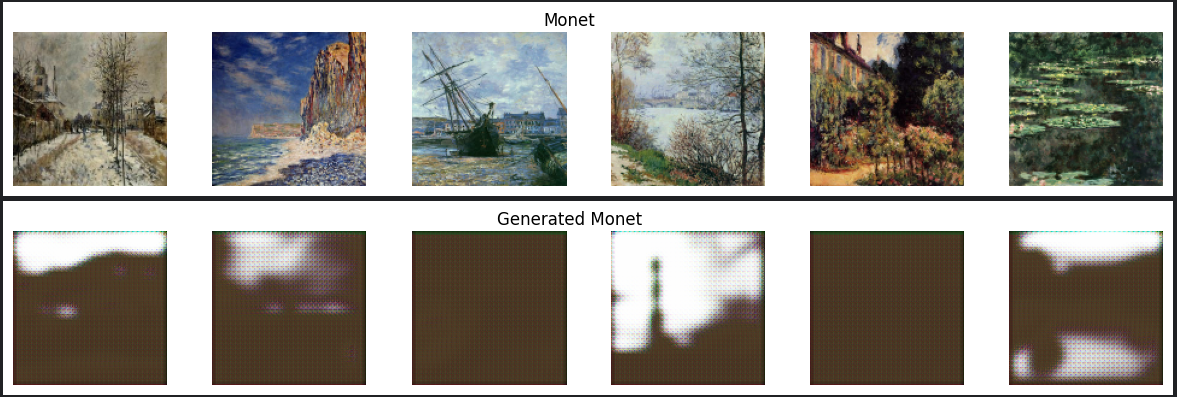
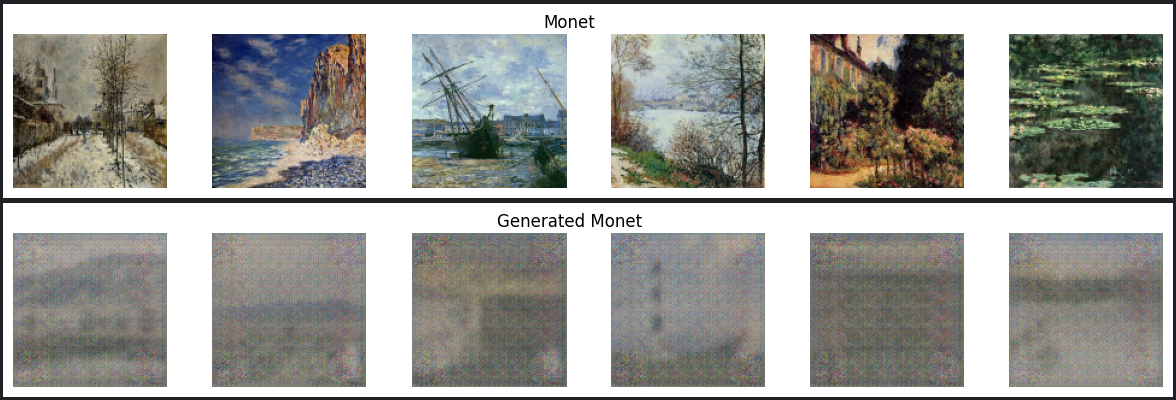
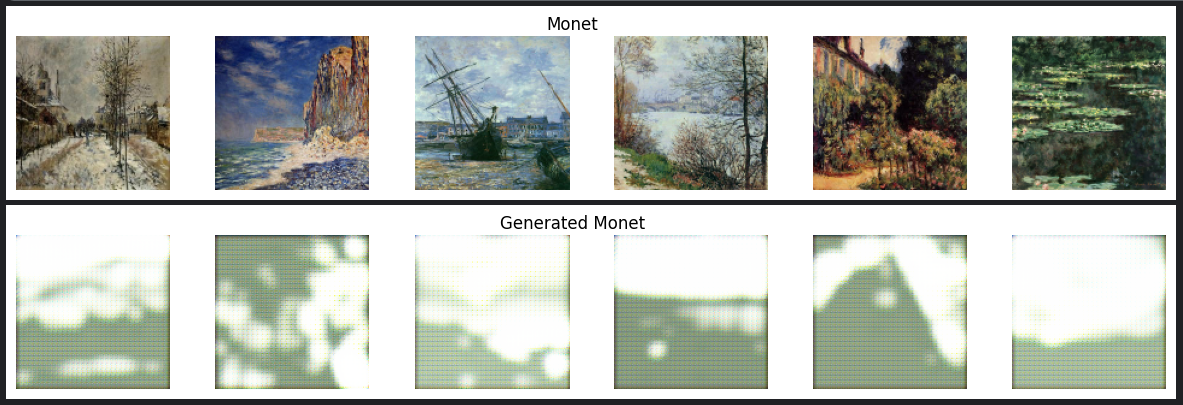
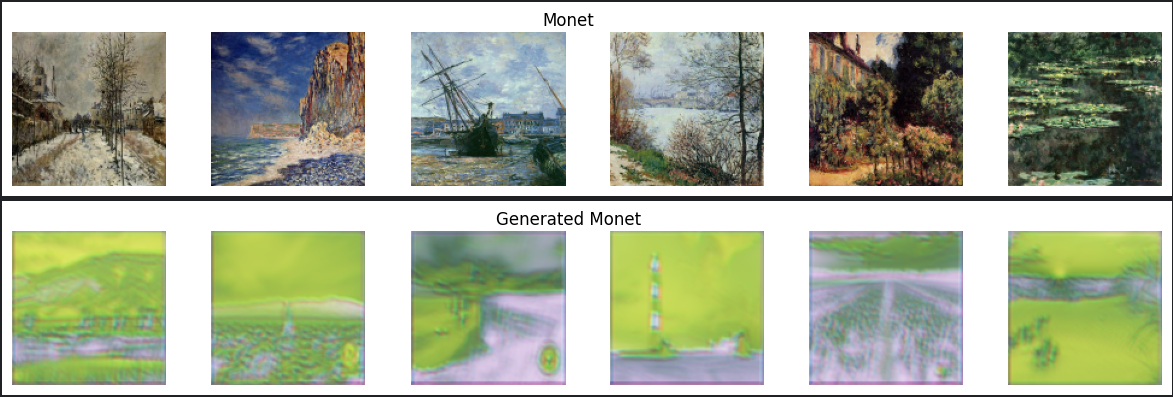
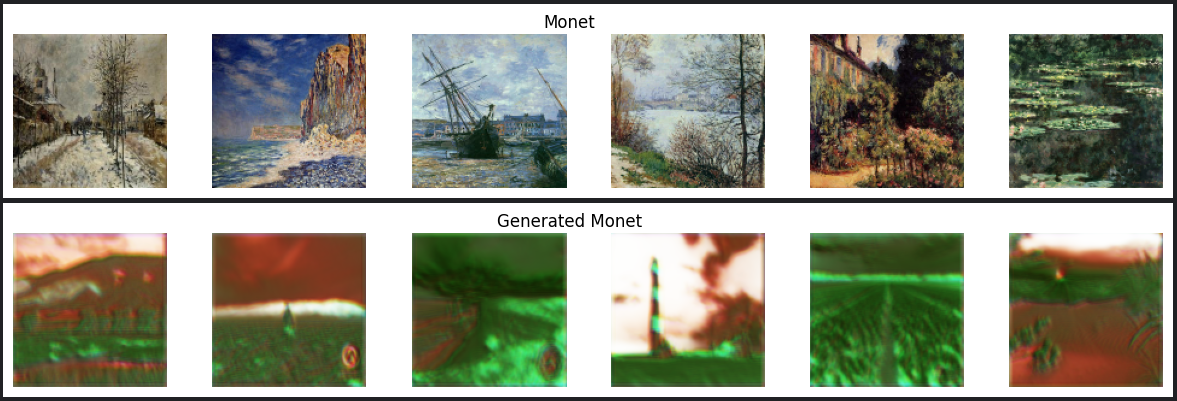
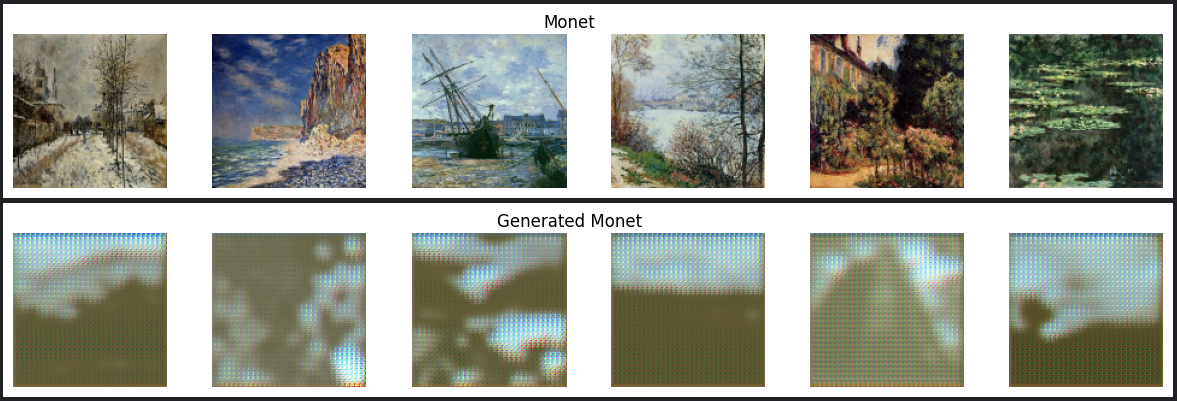

### Resources
- https://www.tensorflow.org/tutorials/generative/dcgan
- https://keras.io/examples/generative/dcgan_overriding_train_step/
- https://www.tensorflow.org/api_docs/python/tf/GradientTape